In [4]:
#important library:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

## load train and test data
# important steps we need:
- augmentation the train and test data for model to avoid the overfitting
- normalize the directories

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
image_size = (224, 224)  # Rescale images to 224x224 pixels
batch_size = 32

# Define paths to the original training and test directories
train_dir = '/home/akz-portable/programming/Datasets/Melanoma_Cancer/train'
test_dir = '/home/akz-portable/programming/Datasets/Melanoma_Cancer/test'

# Get the list of subdirectories in the original training directory
subdirectories = os.listdir(train_dir)

# Split the subdirectories into training and validation sets
train_subdirs, validation_subdirs = train_test_split(subdirectories, test_size=0.2, random_state=42)

# Create directories for training and validation data
train_data_dir = 'path/to/train_data'
os.makedirs(train_data_dir, exist_ok=True)

validation_data_dir = 'path/to/validation_data'
os.makedirs(validation_data_dir, exist_ok=True)

# Move images to the corresponding directories
for subdir in subdirectories:
    filenames = os.listdir(os.path.join(train_dir, subdir))
    train_filenames, validation_filenames = train_test_split(filenames, test_size=0.2, random_state=42)
    
    for filename in train_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(train_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for filename in validation_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(validation_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

# Define data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Print the number of samples in each class for training and validation
print("Number of samples in training set:")
print(train_generator.classes)
print("\nNumber of samples in validation set:")
print(validation_generator.classes)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 9503 images belonging to 2 classes.
Found 2376 images belonging to 2 classes.
Number of samples in training set:
[0 0 0 ... 1 1 1]

Number of samples in validation set:
[0 0 0 ... 1 1 1]
Found 2000 images belonging to 2 classes.


- show the images in the train directory:

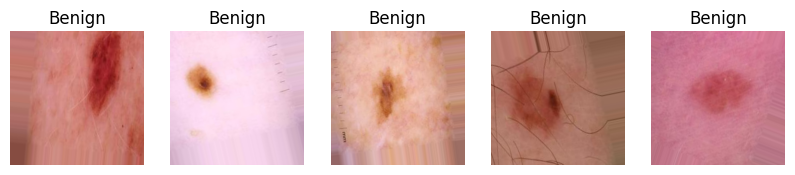

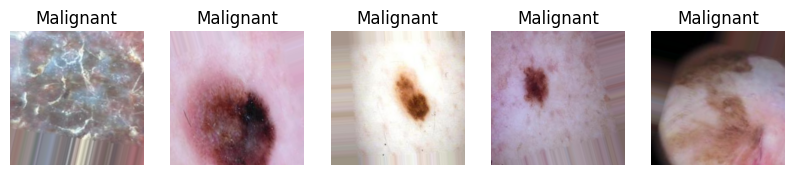

In [6]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = test_generator.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]
    
    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

- show the images in the test directory:

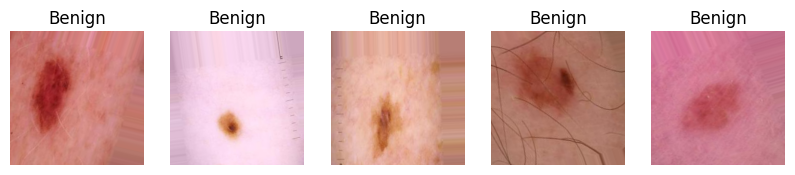

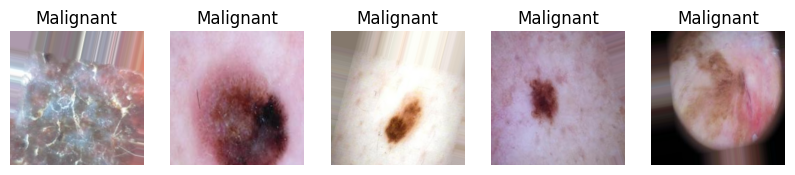

In [7]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = train_generator.class_indices

class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]
    
    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()


- build the model:

In [8]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, BatchNormalization


# Define the input shape
input_shape = (224, 224, 3) 

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling ='max')
x = base_model.output
BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)  # Add dropout layer
output = layers.Dense(2, activation='softmax')(x)

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])



219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


- train the model:

In [9]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history1 = model.fit(train_generator, epochs=20, validation_data=validation_generator)



Epoch 1/20


/home/akz-portable/programming/NNML-SRM/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 43/297 ━━━━━━━━━━━━━━━━━━━━ 41:36 10s/step - accuracy: 0.7048 - loss: 1.2589

KeyboardInterrupt: 

- test the trainable model:

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.9552 - loss: 0.1646
Test Accuracy: 0.9495000243186951


- plot the loss in each epoch

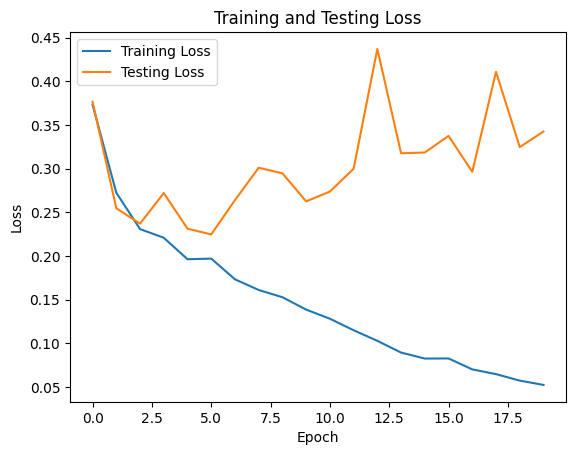

In [ ]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()


- plot the accuracy in each epoch

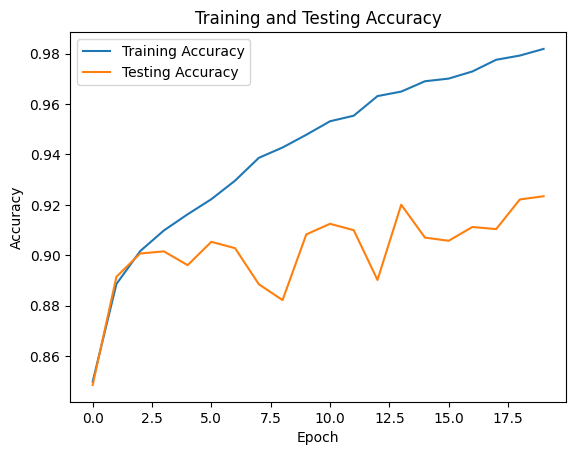

In [ ]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

- confusion matric and classification report:

In [ ]:
predictions = model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print('----------------------------------------------------------------------------------------------')

class_report = classification_report(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)


63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 275ms/step
Confusion Matrix:
[[949  51]
 [ 50 950]]
----------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1000
           1       0.95      0.95      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



- plot the confusion matrix
:

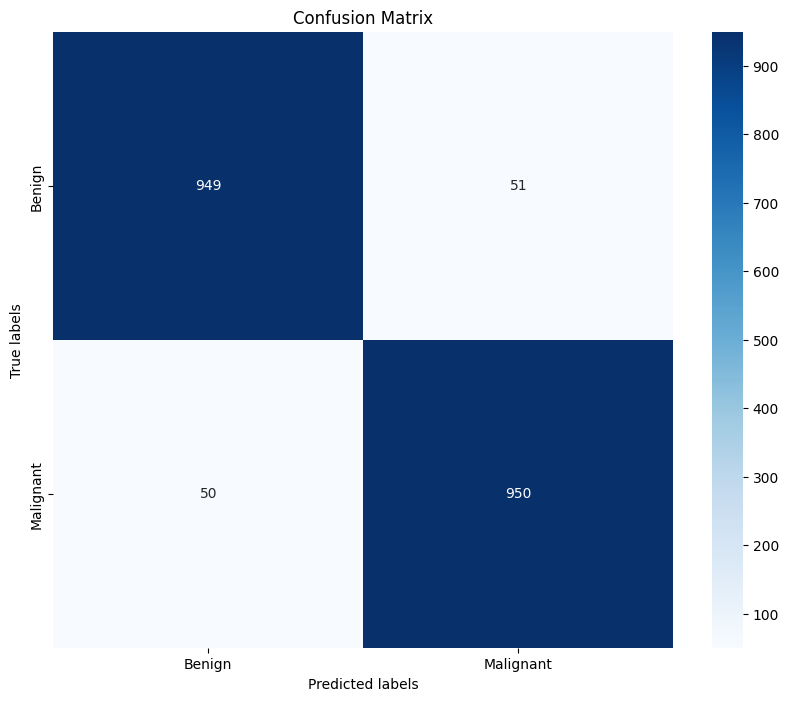

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save("jo33_model_v222.h5")  # Use a different file name
